# Dependencies

In [75]:
from scipy.io import wavfile as wv
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import scipy.io
from genericpath import isdir
from os import listdir
from os.path import isfile, join
from scipy.fftpack import fft
import time
import librosa
import librosa.display

# Data ingestion


*   upload the given dataset on your google drive
*   mount the drive
*   assign to the variable mypath the dataset root folder path
*   run the following 4 cells that:
 *   load the data inside x_data and y_label (for wavfile library)
 *   load the data inside x_data_freq and y_label_freq (for librosa library)
 *   apply the filter on the considered categories



In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
DRIVE_PATH = "./drive/MyDrive/datasets/genres/" # drive path of the folder genres

def loadFiles():
  '''
    used for wavfile
    load the data and generate all the labels based on the sub directory name, it returns:
    x_data  shape (samplerate, amplitude of wave)
    y_label shape (label)
  '''
  mypath = DRIVE_PATH 

  x_data = []
  y_label = []

  for f in listdir(mypath):
    sub_path = join(mypath, f)  #f is the name of subdir (genre)
    if isdir(sub_path):
      for sf in listdir(sub_path):
        file_path = join(sub_path, sf)
        if isfile(file_path):
          x_data.append(wv.read(file_path)) # save file
          y_label.append(f)                 # save genre

  return np.array(x_data, dtype='object'),np.array(y_label)

def loadMfcc():
  '''
    used for librosa
    load the data and generate all the labels based on the sub directory name, it returns:
    x_data  shape (amplitude of wave float, samplerate)
    y_label shape (label)
  '''
  mypath = DRIVE_PATH 

  x_data = []
  y_label = []

  for f in listdir(mypath):
    sub_path = join(mypath, f)  #f is the name of subdir (genre)
    if isdir(sub_path):
      for sf in listdir(sub_path):
        file_path = join(sub_path, sf)
        if isfile(file_path):
          x_data.append(librosa.load(file_path)) # save file
          y_label.append(f)                 # save genre

  return np.array(x_data, dtype='object'),np.array(y_label)

In [78]:
# data loading
timestamp = time.time()
x_data,y_label = loadFiles()
x_data_freq, y_label_freq = loadMfcc()
timestamp -= time.time()
print(f"last load took: {str(np.abs(timestamp))[:3]} seconds")

last load took: 23. seconds


In [79]:
# filter data (comment not needed categories)
filter_masks = [
                y_label == 'pop',
                y_label == 'classical',
                y_label == 'metal',
 #               y_label == 'blues',
 #               y_label == 'disco',
 #               y_label == 'jazz',
 #               y_label == 'hiphop',
 #               y_label == 'country',
 #               y_label == 'rock',
 #               y_label == 'reggae'
]

total_filter = np.zeros((len(y_label)), dtype='bool')
for mask in filter_masks:
  total_filter += mask

# apply category filter
x_data = x_data[total_filter]
x_data_freq = x_data_freq[total_filter]
y_label = y_label[total_filter]
y_label_freq = y_label_freq[total_filter]

# Data preparation

* shuffle the data
* split training and test data (90% and 10%)

Comment: used y_label for bot x_data and x_data_freq since they have been shuffled with the same indexes 

In [80]:
# generate indexes for shuffling
indexes = np.array(range(len(y_label)))
np.random.seed(0)
np.random.shuffle(indexes)

# shuffle
x_data = x_data[indexes]
x_data_freq = x_data_freq[indexes]
y_label = y_label[indexes]


# split proportions
n_total = len(y_label)
n_train = int(0.9 * n_total)

# split
x_test =  x_data[n_train:]
x_test_freq =  x_data_freq[n_train:]
y_test = y_label[n_train:]

x_train =  x_data[:n_train]
x_train_freq =  x_data_freq[:n_train]
y_train = y_label[:n_train]

In [81]:
# show test set content
words = y_test
title = list(Counter(words).keys())# equals to list(set(words))
count = list(Counter(words).values()) # counts the elements' frequency
print("Test set content\n")
for i in range(len(title)):
  print(f'{title[i]}:    \t{count[i]}')

Test set content

pop:    	10
metal:    	11
classical:    	9


In [82]:
# show training set content
words = y_train
title = list(Counter(words).keys())# equals to list(set(words))
count = list(Counter(words).values()) # counts the elements' frequency
print("Train set content\n")
for i in range(len(title)):
  print(f'{title[i]}:    \t{count[i]}')

Train set content

pop:    	90
metal:    	89
classical:    	91


# Algorithm and feature functions

  all the feature function require data in the form of x_data (not x_data_freq)

This block of cells has to be executed again if the training set changes

In [83]:
# avg ZCR for samples of a wave
def ZCR_samples(x_data, n_samples=1000):
  wave_data = x_data[:,1]
  res = []
  for w in wave_data:
    res_tmp = []
    wave_samples = np.array_split(w,n_samples)
    for ws in wave_samples:
      arr1 = np.sign(ws[0:-1])
      arr2 = np.sign(ws[1:])
      res_tmp.append(np.sum(np.abs(arr1-arr2)) / arr1.shape[0])
    res.append(np.mean(res_tmp))
  return np.array(res)

# energy of the signal
def E(x_data):
  wave_data = x_data[:,1]
  res = []
  for w in wave_data:
    res.append(np.mean(w**2))
  return np.array(res)

# silence rateo
def SR_samples(x_data, n_samples=1000):
  wave_data = x_data[:,1]
  res = []
  threshold = np.mean(E(x_train)) # average energy of the training set
  for w in wave_data:
    res_tmp = []
    wave_samples = np.array_split(w,n_samples)
    for ws in wave_samples:
      denominator = np.sum((ws**2) >= threshold*0.8)
      safe_denominator = 1 if denominator == 0 else denominator       # avoid division by 0
      res_tmp.append(np.sum((ws**2) < threshold) / safe_denominator)  # compare energy of the sample vs the average
    res.append(np.mean(res_tmp))
  return np.array(res)

# knn definition
def knn_general(all_labels, dimensions, computed_features, k=3):
  '''
    x_sample has to be an item directly from x_data
    dimensions has to be a list of dimensions normalized (list of computed features for known elements)
    computed features has to match the number of dimensions (computed features for unknown element)
  '''
  total_distances = np.zeros((dimensions[0].shape[0]))  # one distance for every point in feature space
  for i in range(len(dimensions)):                      # for each point in feature space
    total_distances = total_distances + (dimensions[i] - computed_features[i])**2
  
  total_distances = np.sqrt(total_distances)
  index_nn = total_distances.argsort()[:k]          # pick the k args of the smallest distances
  nn_labels = all_labels[index_nn].tolist()         # convert them to list 

  return max(set(nn_labels), key = nn_labels.count) # return the most frequent item in the list

# Training features computation

In [84]:
timestamp = time.time()

# features calculation and normalization td
zcr_res = ZCR_samples(x_train)
sr_res = SR_samples(x_train)
e_res = E(x_train)

zcr_mean = np.mean(zcr_res)
zcr_std = np.std(zcr_res)
zcr_res = (zcr_res - zcr_mean) / zcr_std

sr_mean = np.mean(sr_res)
sr_std = np.std(sr_res)
sr_res = (sr_res - sr_mean) / sr_std

e_mean = np.mean(e_res)
e_std = np.std(e_res)
e_res = (e_res - e_mean) / e_std


# ! parameters frequency domain !
n_mfcc = 13

# mfcc matrix
mfcc_data =  []
for w in x_train_freq[:, 0]:
  mfcc_data.append(librosa.feature.mfcc(w, sr=22050, n_mfcc=n_mfcc))

# mfcc delta and deltadelta
delta_mfccs= []
delta2_mfccs= []
for r in mfcc_data:
  delta_mfccs.append(librosa.feature.delta (r))
  delta2_mfccs.append(librosa.feature.delta (r, order=2))

# mfcc comprehensive concatenation
comprehensive_mfccs = []
for i in range(len(mfcc_data)):
  comprehensive_mfccs.append(np.concatenate ((mfcc_data[i], delta_mfccs[i], delta2_mfccs[i])))

# calculate matrix of song x avg-energy-per-mel-band
matrix_avg_energy_mel_band = []
for song_frequecies in mfcc_data:
  matrix_avg_energy_mel_band.append(np.array([np.mean(song_frequecies[i]**2) for i in range(n_mfcc)]))
matrix_avg_energy_mel_band = np.array(matrix_avg_energy_mel_band)

# calculate matrix of song x avg-energy-per-comprehensive_mfcc_features
matrix_avg_energy_comprehensive = []
for song_frequecies in comprehensive_mfccs:
  matrix_avg_energy_comprehensive.append(np.array([np.mean(song_frequecies[i]**2) for i in range(3*n_mfcc)]))
matrix_avg_energy_comprehensive = np.array(matrix_avg_energy_comprehensive)

# pca avg energy-per-mel-band 
D = matrix_avg_energy_mel_band
avg_e_mean = np.mean(D, axis=0)
avg_e_std = np.std(D, axis=0)
D_norm = (D - avg_e_mean) / avg_e_std
U, s, VT = np.linalg.svd(D_norm, full_matrices=False)
avg_e_pca1 = D_norm @ VT.T[:,0]
avg_e_pca2 = D_norm @ VT.T[:,1]
avg_e_pca3 = D_norm @ VT.T[:,2]
avg_e_pca4 = D_norm @ VT.T[:,3]
avg_e_pca5 = D_norm @ VT.T[:,4]
avg_e_pca6 = D_norm @ VT.T[:,5]
avg_vt1 = VT.T[:,0]
avg_vt2 = VT.T[:,1]
avg_vt3 = VT.T[:,2]
avg_vt4 = VT.T[:,3]
avg_vt5 = VT.T[:,4]
avg_vt6 = VT.T[:,5]

# pca avg energy-per-comprehensive_features
D = matrix_avg_energy_comprehensive
comp_e_mean = np.mean(D, axis=0)
comp_e_std = np.std(D, axis=0)
D_norm = (D - comp_e_mean) / comp_e_std
U, s, VT = np.linalg.svd(D_norm, full_matrices=False)
comp_e_pca1 = D_norm @ VT.T[:,0]
comp_e_pca2 = D_norm @ VT.T[:,1]
comp_e_pca3 = D_norm @ VT.T[:,2]
comp_e_pca4 = D_norm @ VT.T[:,3]
comp_e_pca5 = D_norm @ VT.T[:,4]
comp_e_pca6 = D_norm @ VT.T[:,5]
comp_vt1 = VT.T[:,0]
comp_vt2 = VT.T[:,1]
comp_vt3 = VT.T[:,2]
comp_vt4 = VT.T[:,3]
comp_vt5 = VT.T[:,4]
comp_vt6 = VT.T[:,5]

timestamp -= time.time()
print(f"last feature calculation took: {str(np.abs(timestamp))[:3]} seconds")

last feature calculation took: 36. seconds


# Test features computation

In [85]:
# test features evaluation 

zcr_res_test = ZCR_samples(x_test)
sr_res_test = SR_samples(x_test)
e_res_test = E(x_test)

zcr_res_test = (zcr_res_test - zcr_mean) / zcr_std
sr_res_test =  (sr_res_test  - sr_mean)  / sr_std
e_res_test =   (e_res_test   - e_mean)   / e_std

# mfcc matrix
mfcc_data_test =  []
for w in x_test_freq[:, 0]:
  mfcc_data_test.append(librosa.feature.mfcc(w, sr=22050, n_mfcc=n_mfcc))

# mfcc delta and deltadelta
delta_mfccs_test = []
delta2_mfccs_test = []
for r in mfcc_data_test:
  delta_mfccs_test.append(librosa.feature.delta (r))
  delta2_mfccs_test.append(librosa.feature.delta (r, order=2))

# mfcc comprehensive concatenation
comprehensive_mfccs = []
for i in range(len(mfcc_data_test)):
  comprehensive_mfccs.append(np.concatenate ((mfcc_data_test[i], delta_mfccs_test[i], delta2_mfccs_test[i])))

# calculate matrix of song x avg-energy-per-mel-band
matrix_avg_energy_mel_band_test = []
for song_frequecies in mfcc_data_test:
  matrix_avg_energy_mel_band_test.append(np.array([np.mean(song_frequecies[i]**2) for i in range(n_mfcc)]))
matrix_avg_energy_mel_band_test = np.array(matrix_avg_energy_mel_band_test)

# calculate matrix of song x avg-energy-per-comprehensive_mfcc_features
matrix_avg_energy_comprehensive_test = []
for song_frequecies in comprehensive_mfccs:
  matrix_avg_energy_comprehensive_test.append(np.array([np.mean(song_frequecies[i]**2) for i in range(3*n_mfcc)]))
matrix_avg_energy_comprehensive_test = np.array(matrix_avg_energy_comprehensive_test)


D = matrix_avg_energy_mel_band_test
D_norm_avg = (D - avg_e_mean) / avg_e_std

D = matrix_avg_energy_comprehensive_test
D_norm_comp = (D - comp_e_mean) / comp_e_std

avg_e_test1 = D_norm_avg @ avg_vt1
avg_e_test2 = D_norm_avg @ avg_vt2
avg_e_test3 = D_norm_avg @ avg_vt3
avg_e_test4 = D_norm_avg @ avg_vt4
avg_e_test5 = D_norm_avg @ avg_vt5
avg_e_test6 = D_norm_avg @ avg_vt6

comp_e_test1 = D_norm_comp @ comp_vt1
comp_e_test2 = D_norm_comp @ comp_vt2
comp_e_test3 = D_norm_comp @ comp_vt3
comp_e_test4 = D_norm_comp @ comp_vt4
comp_e_test5 = D_norm_comp @ comp_vt5
comp_e_test6 = D_norm_comp @ comp_vt6

# Performance evaluation

In [86]:
# experiment pipeline definition:

# experiments shape: [[features],[calculated feature for test data]]
experiments = [
               # time domain
               [[zcr_res, sr_res], [zcr_res_test, sr_res_test]],                        #0
               [[zcr_res, sr_res, e_res], [zcr_res_test, sr_res_test, e_res_test]],
               [[sr_res, e_res], [sr_res_test, e_res_test]],

              #avg energy mel band
               [[avg_e_pca1, avg_e_pca2], [avg_e_test1, avg_e_test2]],
               [[avg_e_pca1, avg_e_pca2, avg_e_pca3], [avg_e_test1, avg_e_test2, avg_e_test3]],
               [[avg_e_pca1, avg_e_pca2, avg_e_pca3, avg_e_pca4], [avg_e_test1, avg_e_test2, avg_e_test3, avg_e_test4]],  #5

              # avg energy mel band + time domain
              [[avg_e_pca1, zcr_res], [avg_e_test1, zcr_res_test]],
              [[avg_e_pca1, avg_e_pca2, zcr_res], [avg_e_test1, avg_e_test2, zcr_res_test]],
              [[avg_e_pca1, avg_e_pca2, avg_e_pca3, zcr_res], [avg_e_test1, avg_e_test2, avg_e_test3, zcr_res_test]],
              [[avg_e_pca1, avg_e_pca2, avg_e_pca3, avg_e_pca4, zcr_res], [avg_e_test1, avg_e_test2, avg_e_test3, avg_e_test4, zcr_res_test]],

              #avg energy comprehensive matrix
               [[comp_e_pca1, comp_e_pca2], [comp_e_test1, comp_e_test2]],  # 10
               [[comp_e_pca1, comp_e_pca2, comp_e_pca3], [comp_e_test1, comp_e_test2, comp_e_test3]],
               [[comp_e_pca1, comp_e_pca2, comp_e_pca3, comp_e_pca4], [comp_e_test1, comp_e_test2, comp_e_test3, comp_e_test4]],
               [[comp_e_pca1, comp_e_pca2, comp_e_pca3, comp_e_pca4, comp_e_pca5], [comp_e_test1, comp_e_test2, comp_e_test3, comp_e_test4, comp_e_test5]],
               [[comp_e_pca1, comp_e_pca2, comp_e_pca3, comp_e_pca4, comp_e_pca5, comp_e_pca6], [comp_e_test1, comp_e_test2, comp_e_test3, comp_e_test4, comp_e_test5, comp_e_test6]],

               #avg energy comprehensive matrix + time domain
               [[comp_e_pca1, zcr_res], [comp_e_test1, zcr_res_test]],  # 15
               [[comp_e_pca2, zcr_res], [comp_e_test2, zcr_res_test]],

               [[comp_e_pca1, sr_res], [comp_e_test1, sr_res_test]],
               [[comp_e_pca2, sr_res], [comp_e_test2, sr_res_test]],

               [[comp_e_pca1, comp_e_pca2, zcr_res], [comp_e_test1, comp_e_test2, zcr_res_test]],
               [[comp_e_pca1, comp_e_pca2, comp_e_pca3, zcr_res], [comp_e_test1, comp_e_test2, comp_e_test3, zcr_res_test]],    #20
               [[comp_e_pca1, comp_e_pca2, sr_res], [comp_e_test1, comp_e_test2, sr_res_test]],
               [[comp_e_pca1, comp_e_pca2, sr_res, zcr_res], [comp_e_test1, comp_e_test2, sr_res_test, zcr_res_test]],
]

In [87]:
# run experiments

experiment_counter = 0
experiment_history = []
verbose_test = False
#verbose_test = True

for e in experiments:
  dimensions= e[0]
  
  for k_raw in np.linspace(1,20,20):
    k = int(k_raw)
    truth = []

    for i in range(len(y_test)):
      computed_features = []

      for feature in e[1]:
        computed_features.append(feature[i])
      truth.append(knn_general(y_train, dimensions, computed_features, k) == y_test[i])

    accuracy = np.mean(np.array(truth))
    if verbose_test:
      print(f'experiment: {experiment_counter}\t k_value: {k}\t test accuracy: {accuracy}')
    experiment_history.append((accuracy, experiment_counter, k))

  experiment_counter += 1
  if verbose_test:
    print("\n")

In [88]:
# sort by accuracy and print the report
n_results = 40
sorted_by_accuracy = sorted(experiment_history, key=lambda tup: tup[0], reverse=True)
for acc, exp, k in sorted_by_accuracy[:n_results]:
  print(f'experiment: {exp}\t accuracy: {acc}\t with k:{k}')

experiment: 9	 accuracy: 1.0	 with k:4
experiment: 11	 accuracy: 1.0	 with k:4
experiment: 12	 accuracy: 1.0	 with k:1
experiment: 12	 accuracy: 1.0	 with k:2
experiment: 12	 accuracy: 1.0	 with k:4
experiment: 13	 accuracy: 1.0	 with k:1
experiment: 13	 accuracy: 1.0	 with k:3
experiment: 13	 accuracy: 1.0	 with k:4
experiment: 13	 accuracy: 1.0	 with k:6
experiment: 14	 accuracy: 1.0	 with k:1
experiment: 14	 accuracy: 1.0	 with k:2
experiment: 14	 accuracy: 1.0	 with k:8
experiment: 21	 accuracy: 1.0	 with k:1
experiment: 21	 accuracy: 1.0	 with k:2
experiment: 3	 accuracy: 0.9666666666666667	 with k:2
experiment: 3	 accuracy: 0.9666666666666667	 with k:3
experiment: 3	 accuracy: 0.9666666666666667	 with k:4
experiment: 3	 accuracy: 0.9666666666666667	 with k:5
experiment: 3	 accuracy: 0.9666666666666667	 with k:6
experiment: 3	 accuracy: 0.9666666666666667	 with k:7
experiment: 3	 accuracy: 0.9666666666666667	 with k:8
experiment: 3	 accuracy: 0.9666666666666667	 with k:9
experimen

In [89]:
# example how to play wav files from np array of train data
from IPython.display import Audio
n_song=50
print(f'You are listening a {y_train[n_song]} song\n')
Audio(x_train[n_song][1], rate = x_train[n_song][0])

You are listening a classical song



# Data Exploration

Here are all the machinery used to explore the dataset and the generated fetures is presented, togheter with some trials of dimensionality reduction using pca.
The following blocks of code are not significant for the delivery but present some data exploration experiments that we conduct in the phase of feature definition, the list is not complete but gives a general overview

# Setup

In [90]:
# data loading for feature exploration
timestamp = time.time()
x_data_exploration,y_label_exploration = loadFiles()
x_data_freq_exploration, y_label_freq_exploration = loadMfcc()
timestamp -= time.time()
print(f"last load took: {str(np.abs(timestamp))[:3]} seconds")

mfcc_data_exploration =  []
for w in x_data_freq_exploration[:, 0]:
  mfcc_data_exploration.append(librosa.feature.mfcc(w, sr=22050, n_mfcc=n_mfcc))

# calculate matrix of song x avg-energy-per-mel-band
matrix_avg_energy_mel_band_exploration = []
for song_frequecies in mfcc_data_exploration:
  matrix_avg_energy_mel_band_exploration.append(np.array([np.mean(song_frequecies[i]**2) for i in range(n_mfcc)]))
matrix_avg_energy_mel_band_exploration = np.array(matrix_avg_energy_mel_band_exploration)

comprehensive_mfccs_exploration = []
delta_mfccs_exploration= []
delta2_mfccs_exploration= []

for r in mfcc_data_exploration:
  delta_mfccs_exploration.append(librosa.feature.delta (r))
  delta2_mfccs_exploration.append(librosa.feature.delta (r, order=2))

for i in range(len(x_data_freq_exploration[:,1])):
  comprehensive_mfccs_exploration.append(np.concatenate ((mfcc_data_exploration[i], delta_mfccs_exploration[i], delta2_mfccs_exploration[i])))

# calculate matrix of song x avg-energy-per-cestral-frequency 
avg_energy_comp_exploration = []
for song_frequecies in comprehensive_mfccs_exploration:
  avg_energy_comp_exploration.append(np.array([np.mean(song_frequecies[i]**2) for i in range(3*n_mfcc)]))
avg_energy_comp_exploration = np.array(avg_energy_comp_exploration)

#compute time domain features
zcr_res_exploration = ZCR_samples(x_data_exploration)
sr_res_exploration = SR_samples(x_data_exploration)
e_res_exploration = E(x_data_exploration)

zcr_mean = np.mean(zcr_res_exploration)
zcr_std = np.std(zcr_res_exploration)
zcr_res_exploration = (zcr_res_exploration - zcr_mean) / zcr_std

sr_mean = np.mean(sr_res_exploration)
sr_std = np.std(sr_res_exploration)
sr_res_exploration = (sr_res_exploration - sr_mean) / sr_std

e_mean = np.mean(e_res_exploration)
e_std = np.std(e_res_exploration)
e_res_exploration = (e_res_exploration - e_mean) / e_std

last load took: 24. seconds


# Mel-Frequency band exploration

rock  jazz  disco  classical


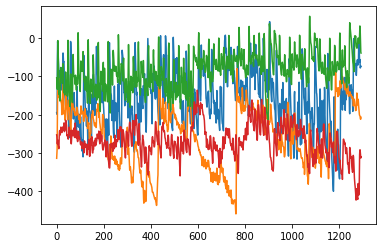

In [91]:
# visualize mel band frequncy band changing the cestral index (delivered implementation 0-12)
cestral_index = 0
plt.plot(mfcc_data_exploration[0][cestral_index])
plt.plot(mfcc_data_exploration[100][cestral_index])
plt.plot(mfcc_data_exploration[200][cestral_index])
plt.plot(mfcc_data_exploration[300][cestral_index])

print(f'{y_label_exploration[0]}  {y_label_exploration[100]}  {y_label_exploration[200]}  {y_label_exploration[300]}')

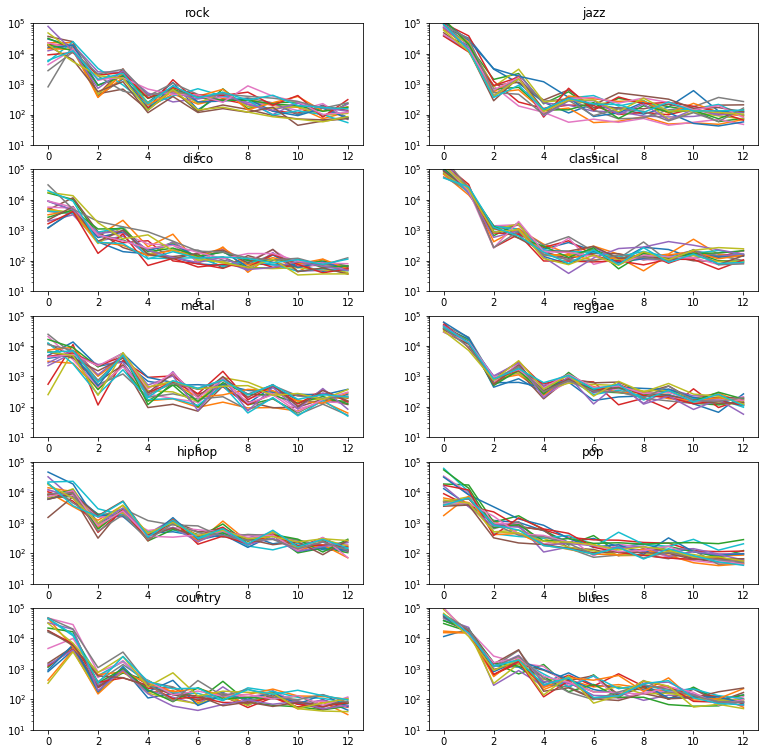

In [92]:
# the trend of average energy for n_songs  of each category
n_songs = 20
n_features = mfcc_data_exploration[0].shape[0]
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=((13,13)))
ax = axs.flatten()
for x in range(10): # iterate each category
  ax[x].set_title(y_label_exploration[100 * x])
  ax[x].set_ylim((10,10e4))
  for y in range(n_songs):
    ax[x].semilogy([np.mean(mfcc_data_exploration[100 * x + y][i]**2) for i in range(n_features)])  #calculate energy for each band

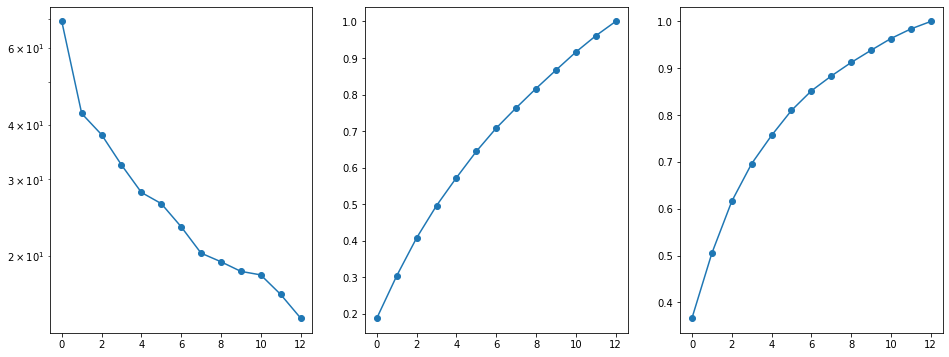

In [93]:
# pca preparation for average energy per mel band
D = matrix_avg_energy_mel_band_exploration
D_norm = (D - np.mean(D, axis=0)) / np.std(D, axis=0)
U, s, VT = np.linalg.svd(D_norm, full_matrices=False)

img, axs = plt.subplots(ncols=3, figsize=(16,6))

axs[0].semilogy(s, '-o')
axs[1].plot(np.cumsum(s) / np.sum(s), '-o')
axs[2].plot(np.cumsum(s**2) / np.sum(s**2), '-o')

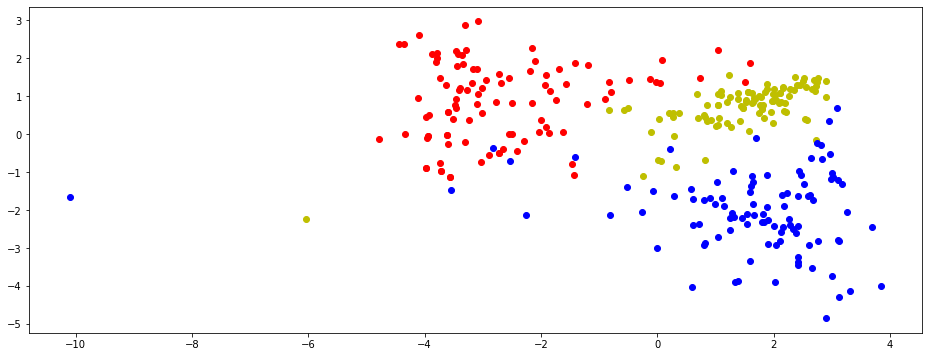

In [94]:
idxs_1 = y_label_exploration == 'pop'
idxs_2 = y_label_exploration == 'classical'
idxs_3 = y_label_exploration == 'metal'
idxs_4 = y_label_exploration == 'blues'
idxs_5 = y_label_exploration == 'disco'
idxs_6 = y_label_exploration == 'jazz'
idxs_7 = y_label_exploration == 'hiphop'
idxs_8 = y_label_exploration == 'country'
idxs_9 = y_label_exploration == 'rock'
idxs_10 = y_label_exploration == 'reggae'

D_pca1 = D_norm @ VT.T[:,0]
D_pca2 = D_norm @ VT.T[:,1]
D_pca3 = D_norm @ VT.T[:,2]

img, axs = plt.subplots(ncols=1, figsize=(16,6))

axs.scatter(D_pca1[idxs_1], D_pca2[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], D_pca2[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], D_pca2[idxs_3], color='r')  # 3
#axs.scatter(D_pca1[idxs_4], D_pca2[idxs_4])  # 4
#axs.scatter(D_pca1[idxs_5], D_pca2[idxs_5])  # 5
#axs.scatter(D_pca1[idxs_6], D_pca2[idxs_6])  # 6
#axs.scatter(D_pca1[idxs_7], D_pca2[idxs_7], color='y')  # 7
#axs.scatter(D_pca1[idxs_8], D_pca2[idxs_8])  # 8
#axs.scatter(D_pca1[idxs_9], D_pca2[idxs_9])  # 9
#axs.scatter(D_pca1[idxs_10], D_pca2[idxs_10], color='r')  # 10

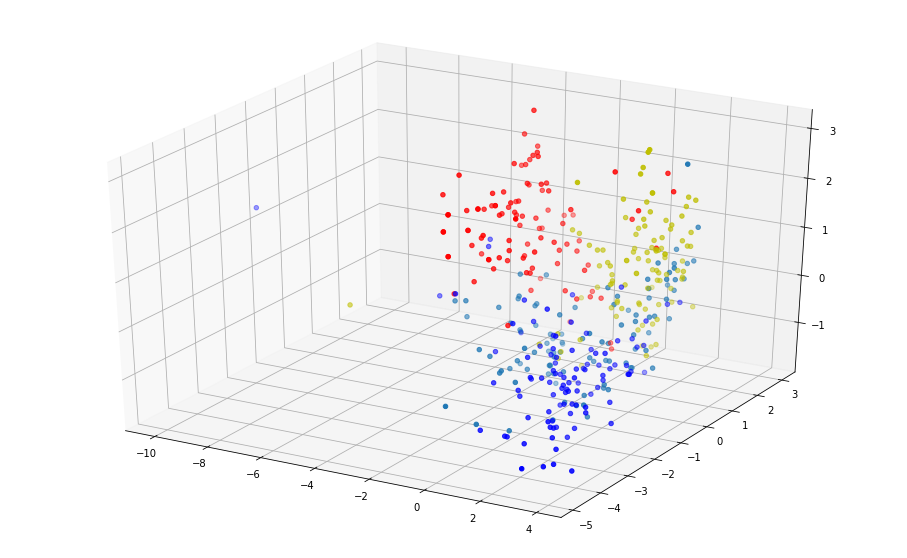

In [95]:
#img, axs = plt.subplots(ncols=1, figsize=(16,6))
fig = plt.figure(figsize=(16,10))
axs = fig.add_subplot(111, projection='3d')

axs.scatter(D_pca1[idxs_1], D_pca2[idxs_1], zcr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], D_pca2[idxs_2], zcr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], D_pca2[idxs_3], zcr_res_exploration[idxs_3], color='r')  # 3
#axs.scatter(D_pca1[idxs_4], D_pca2[idxs_4], zcr_res[idxs_4])  # 4
#axs.scatter(D_pca1[idxs_5], D_pca2[idxs_5], zcr_res[idxs_5])  # 5
#axs.scatter(D_pca1[idxs_6], D_pca2[idxs_6], zcr_res[idxs_6])  # 6
#axs.scatter(D_pca1[idxs_7], D_pca2[idxs_7], zcr_res[idxs_7], color='y')  # 7
axs.scatter(D_pca1[idxs_8], D_pca2[idxs_8], zcr_res_exploration[idxs_8])  # 8
#axs.scatter(D_pca1[idxs_9], D_pca2[idxs_9], zcr_res[idxs_9])  # 9
#axs.scatter(D_pca1[idxs_10], D_pca2[idxs_10], zcr_res[idxs_10], color='r')  # 10

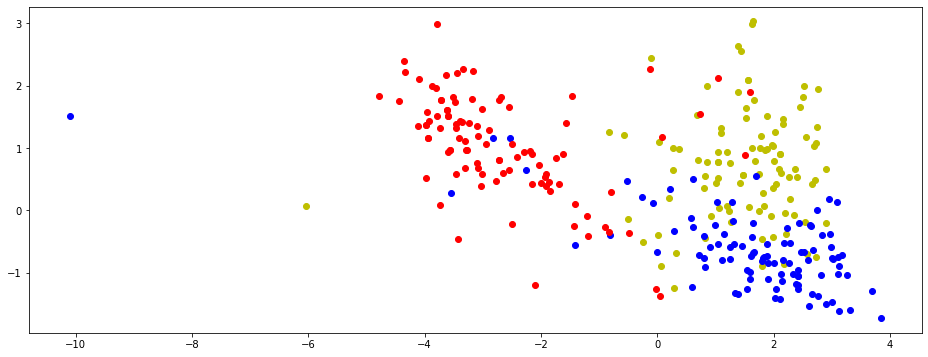

In [96]:
# zcr vs pca1
img, axs = plt.subplots(ncols=1, figsize=(16,6))
axs.scatter(D_pca1[idxs_1], zcr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], zcr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], zcr_res_exploration[idxs_3], color='r')  # 3

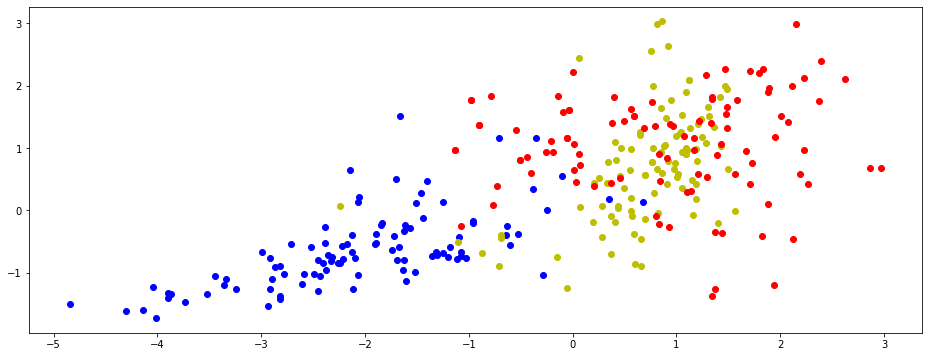

In [97]:
# zcr vs pca2
img, axs = plt.subplots(ncols=1, figsize=(16,6))
axs.scatter(D_pca2[idxs_2], zcr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca2[idxs_1], zcr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca2[idxs_3], zcr_res_exploration[idxs_3], color='r')  # 3

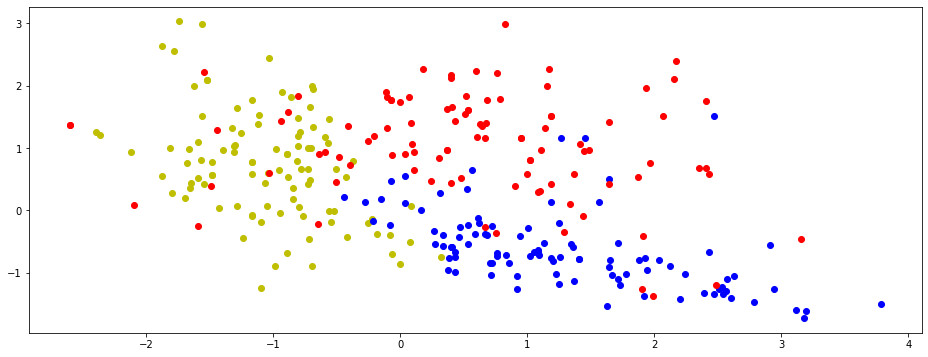

In [98]:
# zcr vs pca3
img, axs = plt.subplots(ncols=1, figsize=(16,6))
axs.scatter(D_pca3[idxs_1], zcr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca3[idxs_2], zcr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca3[idxs_3], zcr_res_exploration[idxs_3], color='r')  # 3

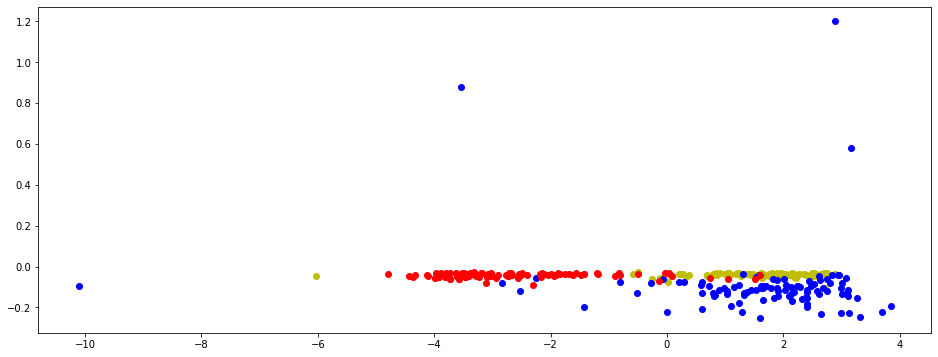

In [99]:
# sr vs pca1
img, axs = plt.subplots(ncols=1, figsize=(16,6))
axs.scatter(D_pca1[idxs_1], sr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], sr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], sr_res_exploration[idxs_3], color='r')  # 3

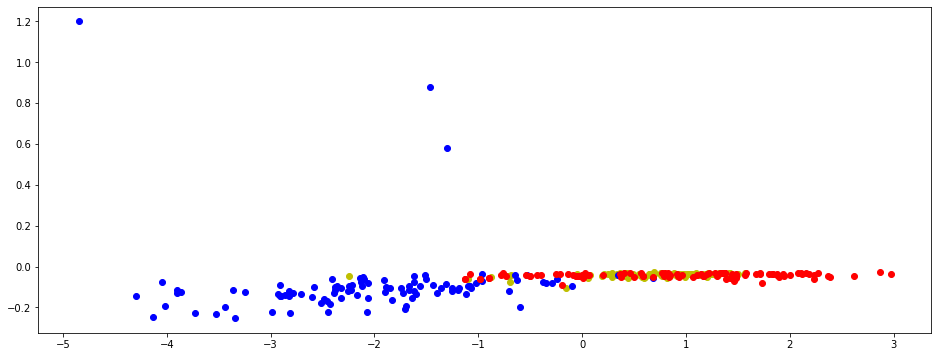

In [100]:
# sr vs pca2
img, axs = plt.subplots(ncols=1, figsize=(16,6))
axs.scatter(D_pca2[idxs_1], sr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca2[idxs_2], sr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca2[idxs_3], sr_res_exploration[idxs_3], color='r')  # 3

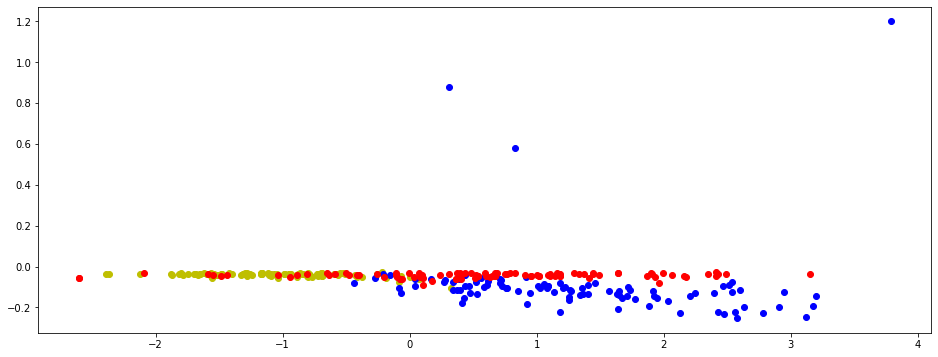

In [101]:
# sr vs pca3
img, axs = plt.subplots(ncols=1, figsize=(16,6))
axs.scatter(D_pca3[idxs_1], sr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca3[idxs_2], sr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca3[idxs_3], sr_res_exploration[idxs_3], color='r')  # 3

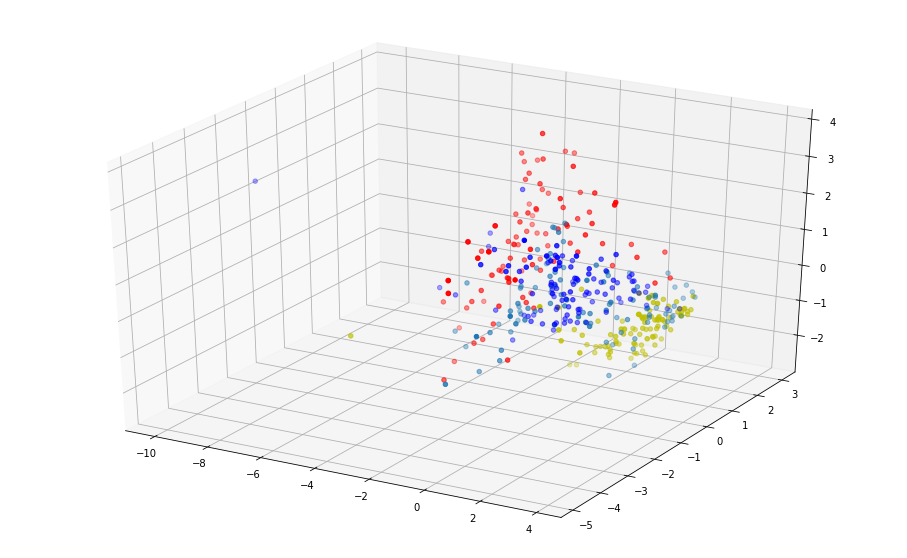

In [102]:
# pca1 vs pca2 vs pca3
# Uncomment the genres you want to include in the graph

#img, axs = plt.subplots(ncols=1, figsize=(16,6))
fig = plt.figure(figsize=(16,10))
axs = fig.add_subplot(111, projection='3d')

axs.scatter(D_pca1[idxs_1], D_pca2[idxs_1], D_pca3[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], D_pca2[idxs_2], D_pca3[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], D_pca2[idxs_3], D_pca3[idxs_3], color='r')  # 3
#axs.scatter(D_pca1[idxs_5], D_pca2[idxs_5], D_pca3[idxs_5])  # 5
#axs.scatter(D_pca1[idxs_4], D_pca2[idxs_4], D_pca3[idxs_4])  # 4
#axs.scatter(D_pca1[idxs_6], D_pca2[idxs_6], D_pca3[idxs_6])  # 6
#axs.scatter(D_pca1[idxs_7], D_pca2[idxs_7], D_pca3[idxs_7], color='y')  # 7
axs.scatter(D_pca1[idxs_8], D_pca2[idxs_8], D_pca3[idxs_8])  # 8
#axs.scatter(D_pca1[idxs_9], D_pca2[idxs_9], D_pca3[idxs_9])  # 9
#axs.scatter(D_pca1[idxs_10], D_pca2[idxs_10], D_pca3[idxs_10], color='r')  # 10

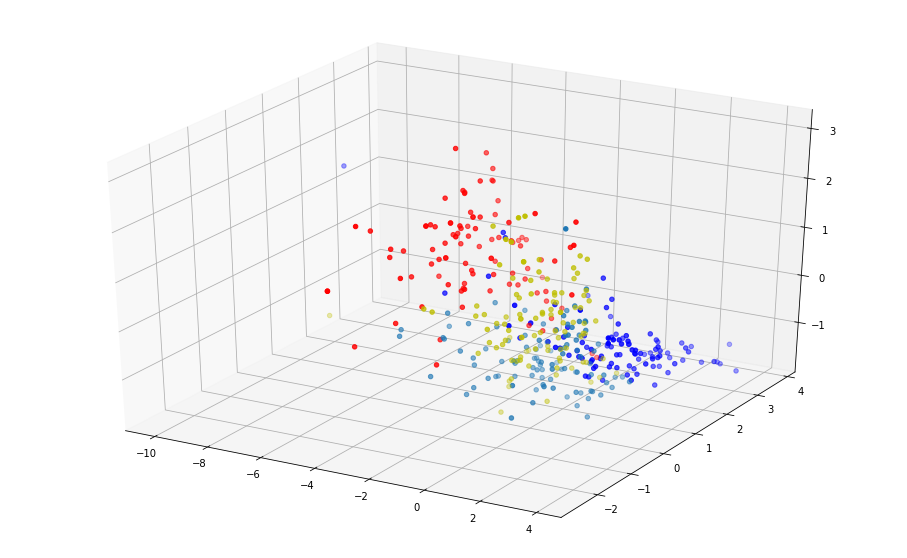

In [103]:
#pca1 vs pca3 vs zcr
# Uncomment the genres you want to include in the graph

#img, axs = plt.subplots(ncols=1, figsize=(16,6))
fig = plt.figure(figsize=(16,10))
axs = fig.add_subplot(111, projection='3d')

axs.scatter(D_pca1[idxs_1], D_pca3[idxs_1], zcr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], D_pca3[idxs_2], zcr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], D_pca3[idxs_3], zcr_res_exploration[idxs_3], color='r')  # 3
#axs.scatter(D_pca1[idxs_4], D_pca3[idxs_4], zcr_res_exploration[idxs_4])  # 4
#axs.scatter(D_pca1[idxs_5], D_pca3[idxs_5], zcr_res_exploration[idxs_5])  # 5
#axs.scatter(D_pca1[idxs_6], D_pca3[idxs_6], zcr_res_exploration[idxs_6])  # 6
#axs.scatter(D_pca1[idxs_7], D_pca3[idxs_7], zcr_res_exploration[idxs_7], color='y')  # 7
axs.scatter(D_pca1[idxs_8], D_pca3[idxs_8], zcr_res_exploration[idxs_8])  # 8
#axs.scatter(D_pca1[idxs_9], D_pca3[idxs_9], zcr_res_exploration[idxs_9])  # 9
#axs.scatter(D_pca1[idxs_10], D_pca3[idxs_10], zcr_res_exploration[idxs_10], color='r')  # 10

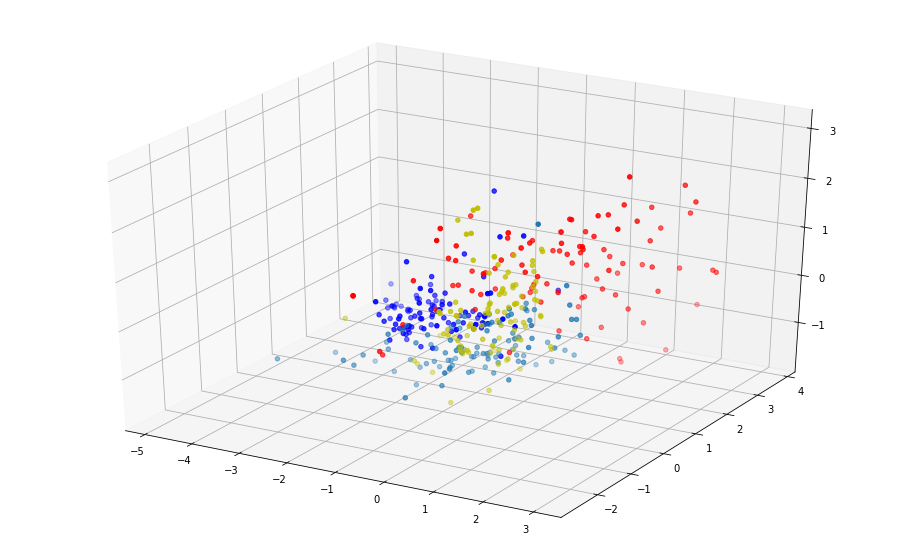

In [104]:
#pca2 vs pca3 vs zcr
# Uncomment the genres you want to include in the graph

#img, axs = plt.subplots(ncols=1, figsize=(16,6))
fig = plt.figure(figsize=(16,10))
axs = fig.add_subplot(111, projection='3d')

axs.scatter(D_pca2[idxs_1], D_pca3[idxs_1], zcr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca2[idxs_2], D_pca3[idxs_2], zcr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca2[idxs_3], D_pca3[idxs_3], zcr_res_exploration[idxs_3], color='r')  # 3
#axs.scatter(D_pca2[idxs_4], D_pca3[idxs_4], zcr_res_exploration[idxs_4])  # 4
#axs.scatter(D_pca2[idxs_5], D_pca3[idxs_5], zcr_res_exploration[idxs_5])  # 5
#axs.scatter(D_pca2[idxs_6], D_pca3[idxs_6], zcr_res_exploration[idxs_6])  # 6
#axs.scatter(D_pca2[idxs_7], D_pca3[idxs_7], zcr_res_exploration[idxs_7], color='y')  # 7
axs.scatter(D_pca2[idxs_8], D_pca3[idxs_8], zcr_res_exploration[idxs_8])  # 8
#axs.scatter(D_pca2[idxs_9], D_pca3[idxs_9], zcr_res_exploration[idxs_9])  # 9
#axs.scatter(D_pca2[idxs_10], D_pca3[idxs_10], zcr_res_exploration[idxs_10], color='r')  # 10

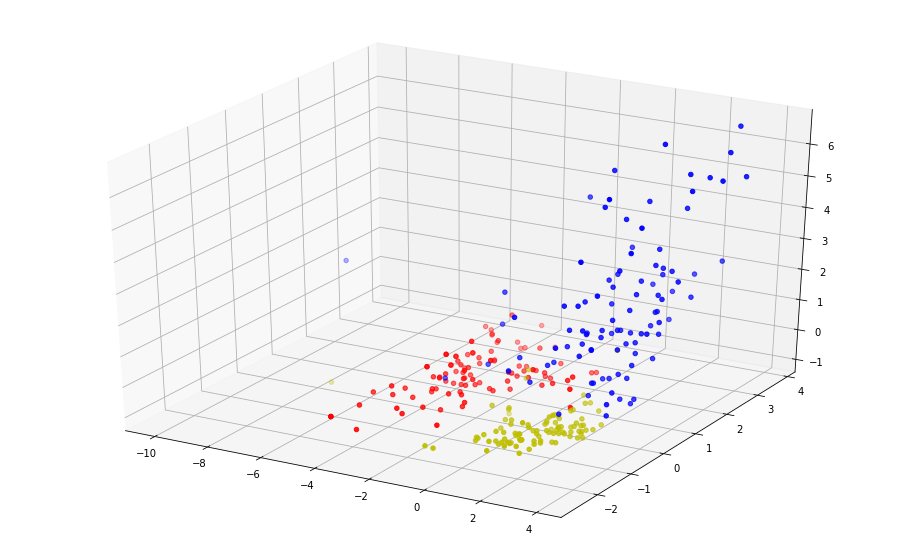

In [105]:
#pca1 vs pca3 vs energy
# Uncomment the genres you want to include in the graph

#img, axs = plt.subplots(ncols=1, figsize=(16,6))
fig = plt.figure(figsize=(16,10))
axs = fig.add_subplot(111, projection='3d')

axs.scatter(D_pca1[idxs_1], D_pca3[idxs_1], e_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], D_pca3[idxs_2], e_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], D_pca3[idxs_3], e_res_exploration[idxs_3], color='r')  # 3
#axs.scatter(D_pca1[idxs_4], D_pca3[idxs_4], e_res_exploration[idxs_4])  # 4
#axs.scatter(D_pca1[idxs_5], D_pca3[idxs_5], e_res_exploration[idxs_5])  # 5
#axs.scatter(D_pca1[idxs_6], D_pca3[idxs_6], e_res_exploration[idxs_6])  # 6
#axs.scatter(D_pca1[idxs_7], D_pca3[idxs_7], e_res_exploration[idxs_7], color='y')  # 7axs.scatter(D_pca1[idxs_8], D_pca3[idxs_8], e_res_exploration[idxs_8])  # 8
#axs.scatter(D_pca1[idxs_9], D_pca3[idxs_9], e_res_exploration[idxs_9])  # 9
#axs.scatter(D_pca1[idxs_10], D_pca3[idxs_10], e_res_exploration[idxs_10], color='r')  # 10

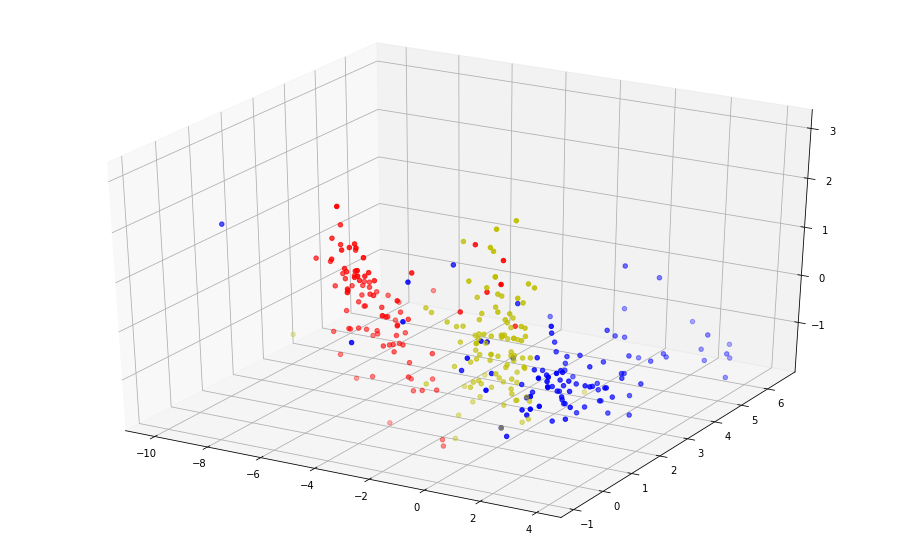

In [106]:
#pca1 vs energy vs zcr
# Uncomment the genres you want to include in the graph

#img, axs = plt.subplots(ncols=1, figsize=(16,6))
fig = plt.figure(figsize=(16,10))
axs = fig.add_subplot(111, projection='3d')

axs.scatter(D_pca1[idxs_1], e_res_exploration[idxs_1], zcr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], e_res_exploration[idxs_2], zcr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], e_res_exploration[idxs_3], zcr_res_exploration[idxs_3], color='r')  # 3
#axs.scatter(D_pca1[idxs_4], e_res_exploration[idxs_4], zcr_res_exploration[idxs_4])  # 4
#axs.scatter(D_pca1[idxs_5], e_res_exploration[idxs_5], zcr_res_exploration[idxs_5])  # 5
#axs.scatter(D_pca1[idxs_6], e_res_exploration[idxs_6], zcr_res_exploration[idxs_6])  # 6
#axs.scatter(D_pca1[idxs_7], e_res_exploration[idxs_7], zcr_res_exploration[idxs_7], color='y')  # 7axs.scatter(D_pca1[idxs_8], D_pca3[idxs_8], e_res_exploration[idxs_8])  # 8
#axs.scatter(D_pca1[idxs_9], e_res_exploration[idxs_9], zcr_res_exploration[idxs_9])  # 9
#axs.scatter(D_pca1[idxs_10], e_res_exploration[idxs_10], zcr_res_exploration[idxs_10], color='r')  # 10

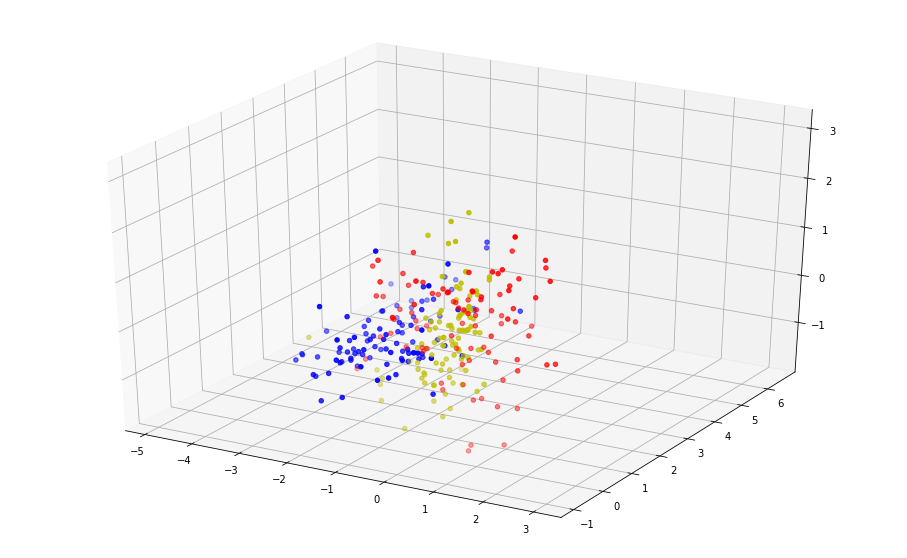

In [107]:
#pca2 vs energy vs zcr
# Uncomment the genres you want to include in the graph

#img, axs = plt.subplots(ncols=1, figsize=(16,6))
fig = plt.figure(figsize=(16,10))
axs = fig.add_subplot(111, projection='3d')

axs.scatter(D_pca2[idxs_1], e_res_exploration[idxs_1], zcr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca2[idxs_2], e_res_exploration[idxs_2], zcr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca2[idxs_3], e_res_exploration[idxs_3], zcr_res_exploration[idxs_3], color='r')  # 3
#axs.scatter(D_pca2[idxs_4], e_res_exploration[idxs_4], zcr_res_exploration[idxs_4])  # 4
#axs.scatter(D_pca2[idxs_5], e_res_exploration[idxs_5], zcr_res_exploration[idxs_5])  # 5
#axs.scatter(D_pca2[idxs_6], e_res_exploration[idxs_6], zcr_res_exploration[idxs_6])  # 6
#axs.scatter(D_pca2[idxs_7], e_res_exploration[idxs_7], zcr_res_exploration[idxs_7], color='y')  # 7axs.scatter(D_pca1[idxs_8], D_pca3[idxs_8], e_res_exploration[idxs_8])  # 8
#axs.scatter(D_pca2[idxs_9], e_res_exploration[idxs_9], zcr_res_exploration[idxs_9])  # 9
#axs.scatter(D_pca2[idxs_10], e_res_exploration[idxs_10], zcr_res_exploration[idxs_10], color='r')  # 10

# Cohmprensive matrix exploration

rock  jazz  disco  classical


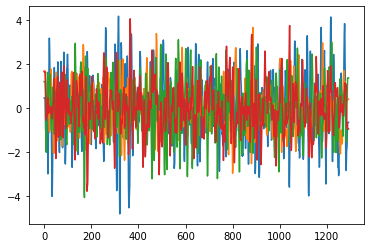

In [108]:
# # exploration of comprehensive mffcs matrix (39 indexes in default delivery)
cestral_index = 24
plt.plot(comprehensive_mfccs_exploration[0][cestral_index])
plt.plot(comprehensive_mfccs_exploration[100][cestral_index])
plt.plot(comprehensive_mfccs_exploration[200][cestral_index])
plt.plot(comprehensive_mfccs_exploration[300][cestral_index])

print(f'{y_label_exploration[0]}  {y_label_exploration[100]}  {y_label_exploration[200]}  {y_label_exploration[300]}')

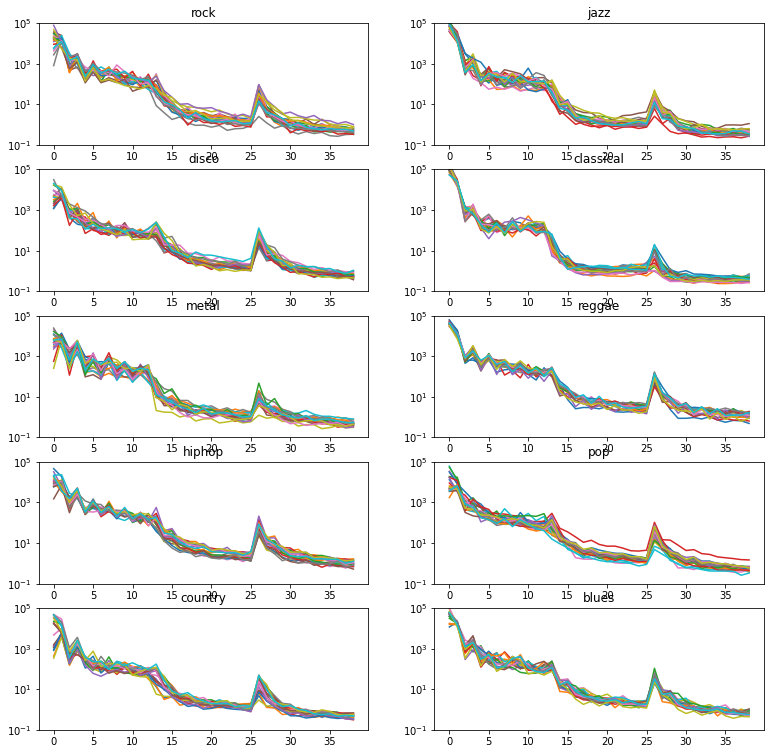

In [109]:
# the trend of average energy per comprehensive matrix feature for n_songs songs of each category
n_features = 3 * n_mfcc
n_songs = 20
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=((13,13)))
ax = axs.flatten()
for x in range(10): # iterate each category
  ax[x].set_title(y_label_exploration[100 * x])
  ax[x].set_ylim((1e-1,10e4))
  for y in range(n_songs):
    ax[x].semilogy([np.mean(comprehensive_mfccs_exploration[100 * x + y][i]**2) for i in range(n_features)])


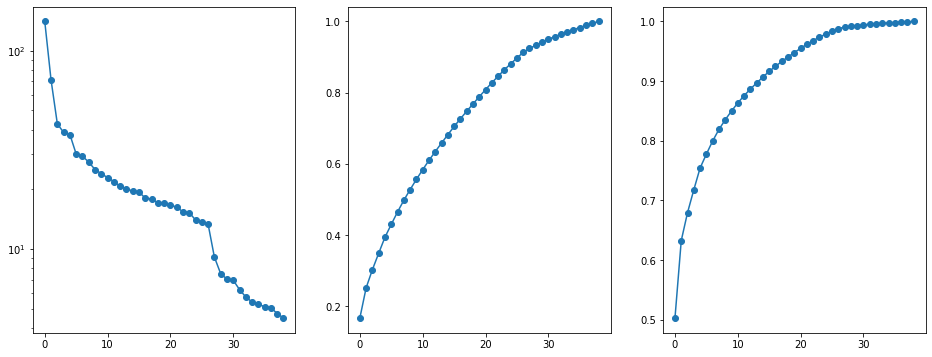

In [110]:
# pca preparation for comprehenzive matrix feature for n_songs songs of each category
D = avg_energy_comp_exploration
D_norm = (D - np.mean(D, axis=0)) / np.std(D, axis=0)
U, s, VT = np.linalg.svd(D_norm, full_matrices=False)

img, axs = plt.subplots(ncols=3, figsize=(16,6))

axs[0].semilogy(s, '-o')
axs[1].plot(np.cumsum(s) / np.sum(s), '-o')
axs[2].plot(np.cumsum(s**2) / np.sum(s**2), '-o')

In [111]:
# pca computation
D_pca1 = D_norm @ VT.T[:,0]
D_pca2 = D_norm @ VT.T[:,1]
D_pca3 = D_norm @ VT.T[:,2]
D_pca4 = D_norm @ VT.T[:,3]
D_pca5 = D_norm @ VT.T[:,4]

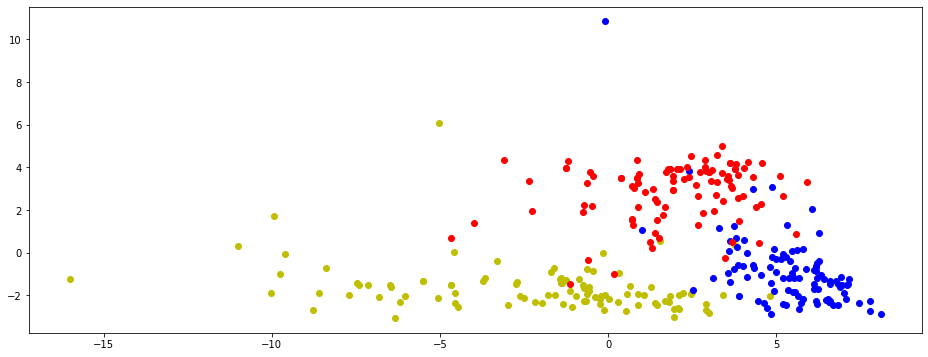

In [112]:
idxs_1 = y_label_exploration == 'pop'
idxs_2 = y_label_exploration == 'classical'
idxs_3 = y_label_exploration == 'metal'
idxs_4 = y_label_exploration == 'blues'
idxs_5 = y_label_exploration == 'disco'
idxs_6 = y_label_exploration == 'jazz'
idxs_7 = y_label_exploration == 'hiphop'
idxs_8 = y_label_exploration == 'country'
idxs_9 = y_label_exploration == 'rock'
idxs_10 = y_label_exploration == 'reggae'


img, axs = plt.subplots(ncols=1, figsize=(16,6))

axs.scatter(D_pca1[idxs_1], D_pca2[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], D_pca2[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], D_pca2[idxs_3], color='r')  # 3
#axs.scatter(D_pca1[idxs_4], D_pca2[idxs_4])  # 4
#axs.scatter(D_pca1[idxs_5], D_pca2[idxs_5])  # 5
#axs.scatter(D_pca1[idxs_6], D_pca2[idxs_6])  # 6
#axs.scatter(D_pca1[idxs_7], D_pca2[idxs_7], color='y')  # 7
#axs.scatter(D_pca1[idxs_8], D_pca2[idxs_8])  # 8
#axs.scatter(D_pca1[idxs_9], D_pca2[idxs_9])  # 9
#axs.scatter(D_pca1[idxs_10], D_pca2[idxs_10], color='r')  # 10

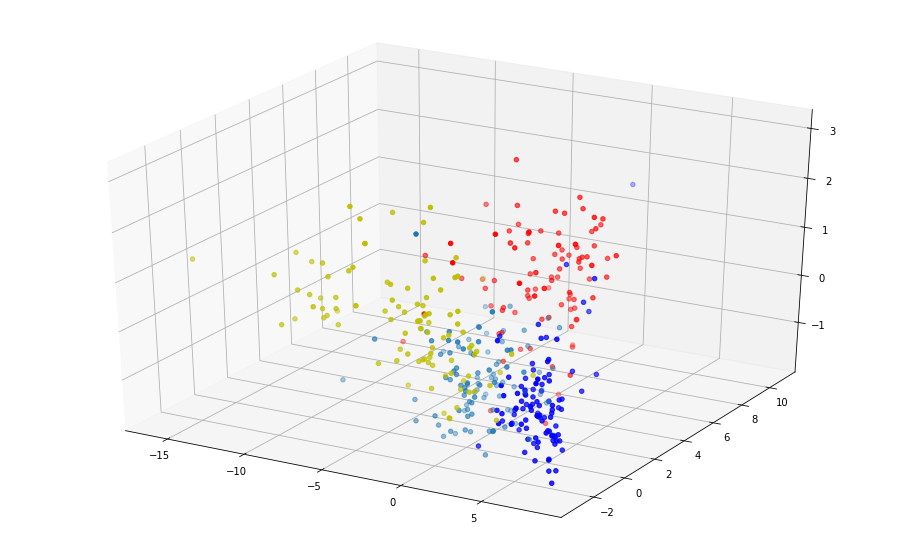

In [113]:
#img, axs = plt.subplots(ncols=1, figsize=(16,6))
fig = plt.figure(figsize=(16,10))
axs = fig.add_subplot(111, projection='3d')

axs.scatter(D_pca1[idxs_1], D_pca2[idxs_1], zcr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], D_pca2[idxs_2], zcr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], D_pca2[idxs_3], zcr_res_exploration[idxs_3], color='r')  # 3
#axs.scatter(D_pca1[idxs_4], D_pca2[idxs_4], zcr_res[idxs_4])  # 4
#axs.scatter(D_pca1[idxs_5], D_pca2[idxs_5], zcr_res[idxs_5])  # 5
#axs.scatter(D_pca1[idxs_6], D_pca2[idxs_6], zcr_res[idxs_6])  # 6
#axs.scatter(D_pca1[idxs_7], D_pca2[idxs_7], zcr_res[idxs_7], color='y')  # 7
axs.scatter(D_pca1[idxs_8], D_pca2[idxs_8], zcr_res_exploration[idxs_8])  # 8
#axs.scatter(D_pca1[idxs_9], D_pca2[idxs_9], zcr_res[idxs_9])  # 9
#axs.scatter(D_pca1[idxs_10], D_pca2[idxs_10], zcr_res[idxs_10], color='r')  # 10

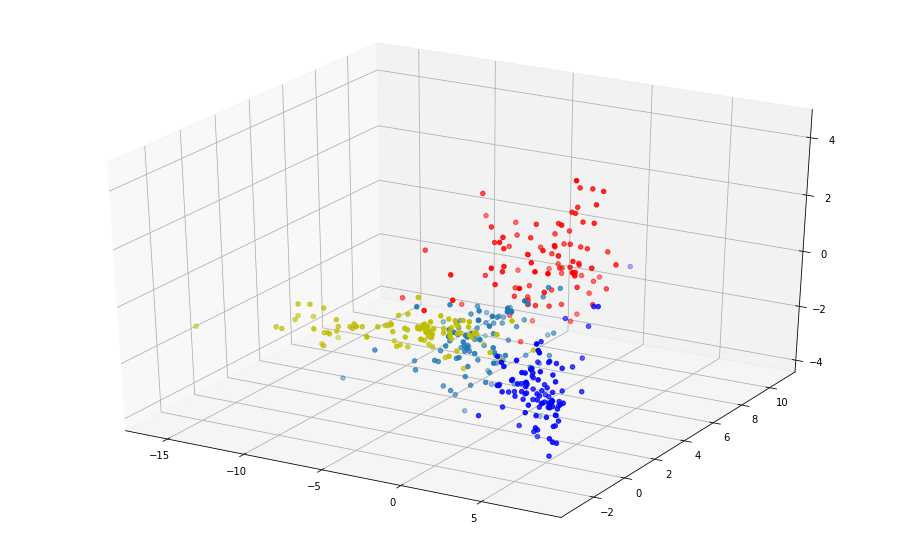

In [114]:
# pca1 vs pca2 vs pca3

#img, axs = plt.subplots(ncols=1, figsize=(16,6))
fig = plt.figure(figsize=(16,10))
axs = fig.add_subplot(111, projection='3d')

axs.scatter(D_pca1[idxs_1], D_pca2[idxs_1], D_pca3[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], D_pca2[idxs_2], D_pca3[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], D_pca2[idxs_3], D_pca3[idxs_3], color='r')  # 3
#axs.scatter(D_pca1[idxs_5], D_pca2[idxs_5], D_pca3[idxs_5])  # 5
#axs.scatter(D_pca1[idxs_4], D_pca2[idxs_4], D_pca3[idxs_4])  # 4
#axs.scatter(D_pca1[idxs_6], D_pca2[idxs_6], D_pca3[idxs_6])  # 6
#axs.scatter(D_pca1[idxs_7], D_pca2[idxs_7], D_pca3[idxs_7], color='y')  # 7
axs.scatter(D_pca1[idxs_8], D_pca2[idxs_8], D_pca3[idxs_8])  # 8
#axs.scatter(D_pca1[idxs_9], D_pca2[idxs_9], D_pca3[idxs_9])  # 9
#axs.scatter(D_pca1[idxs_10], D_pca2[idxs_10], D_pca3[idxs_10], color='r')  # 10

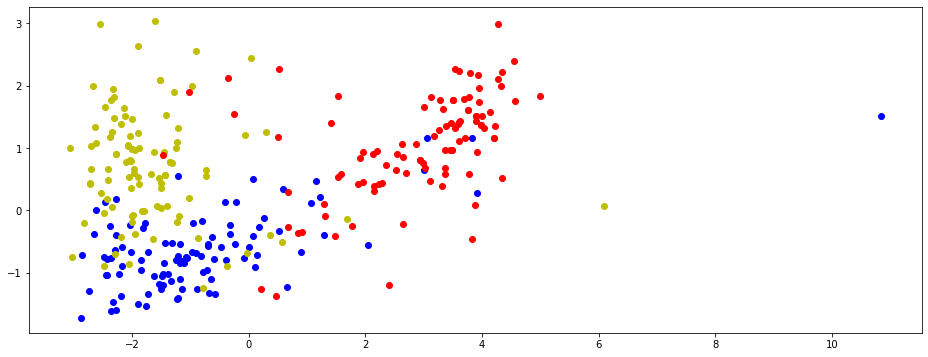

In [115]:
# zcr vs pca2
img, axs = plt.subplots(ncols=1, figsize=(16,6))
axs.scatter(D_pca2[idxs_2], zcr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca2[idxs_1], zcr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca2[idxs_3], zcr_res_exploration[idxs_3], color='r')  # 3

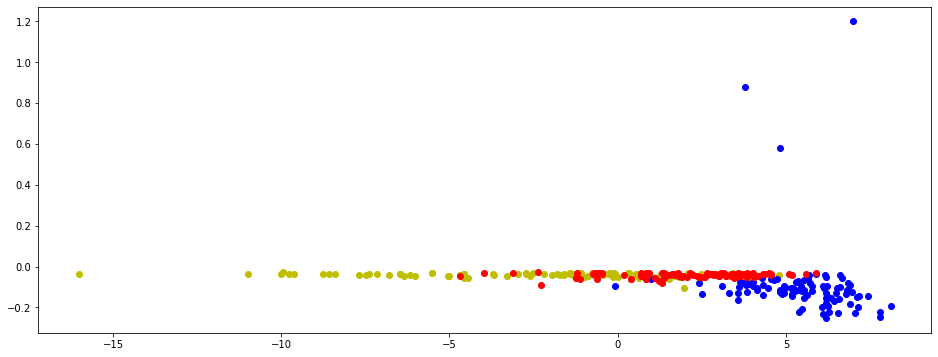

In [116]:
# sr vs pca1
img, axs = plt.subplots(ncols=1, figsize=(16,6))
axs.scatter(D_pca1[idxs_1], sr_res_exploration[idxs_1], color='y')  # 1
axs.scatter(D_pca1[idxs_2], sr_res_exploration[idxs_2], color='b')  # 2
axs.scatter(D_pca1[idxs_3], sr_res_exploration[idxs_3], color='r')  # 3

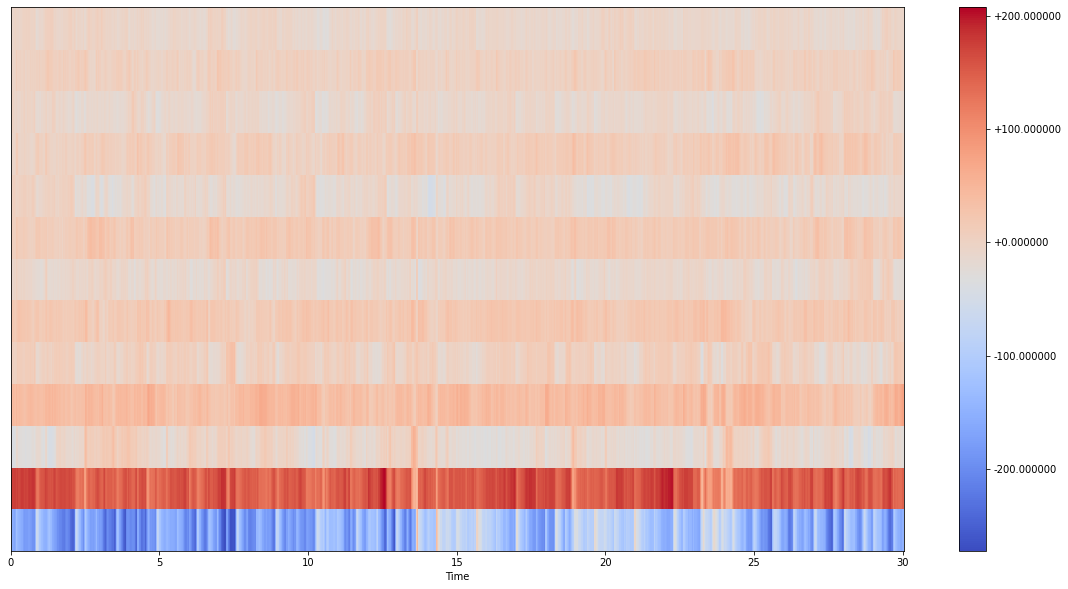

In [117]:
song_index= 1
# plot the content of MFCCs
plt.figure(figsize=(20,10))
librosa.display.specshow(mfcc_data_exploration[song_index], x_axis= "time")
plt.colorbar (format = "%+2f")
plt.show()

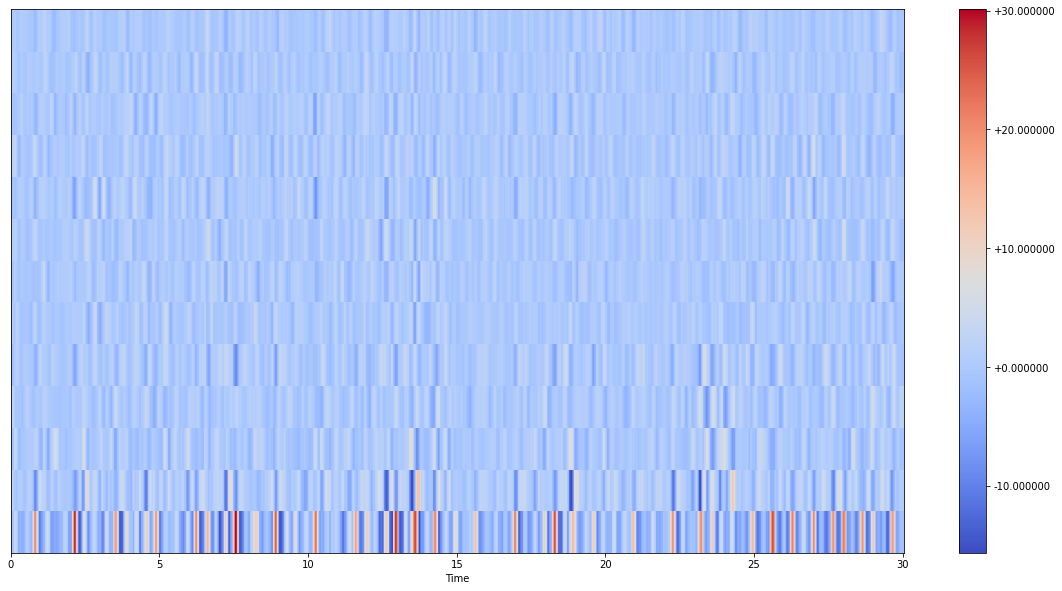

In [118]:
# plot the content of MFCCs delta
plt.figure(figsize=(20,10))
librosa.display.specshow(delta_mfccs_exploration[song_index], x_axis= "time")
plt.colorbar (format = "%+2f")
plt.show()

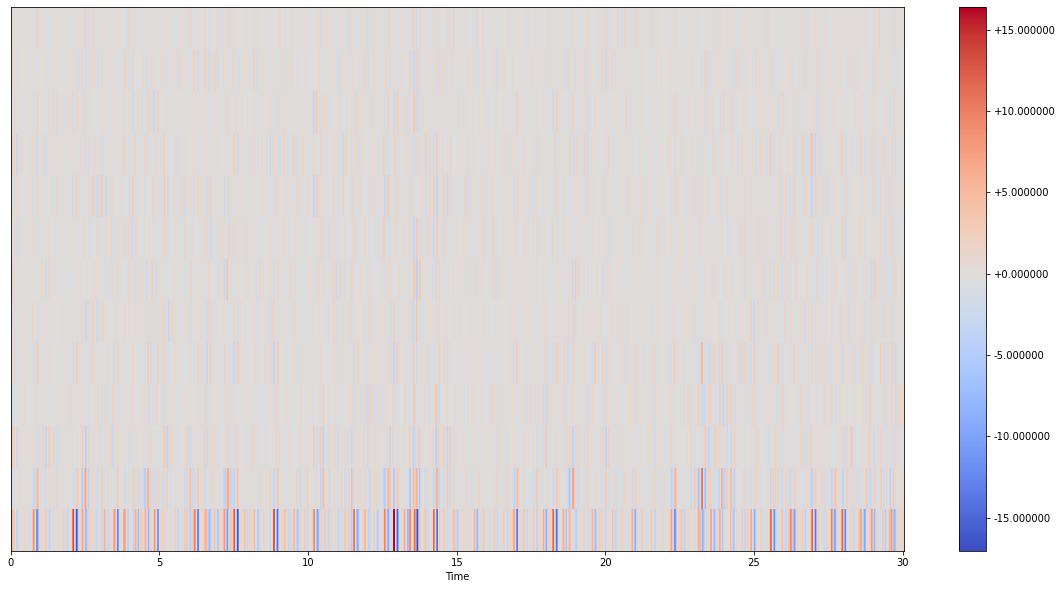

In [119]:
# plot the content of MFCCs delta2
plt.figure(figsize=(20,10))
librosa.display.specshow(delta2_mfccs_exploration[song_index], x_axis= "time")
plt.colorbar (format = "%+2f")
plt.show()

# Herz frequency class exploration

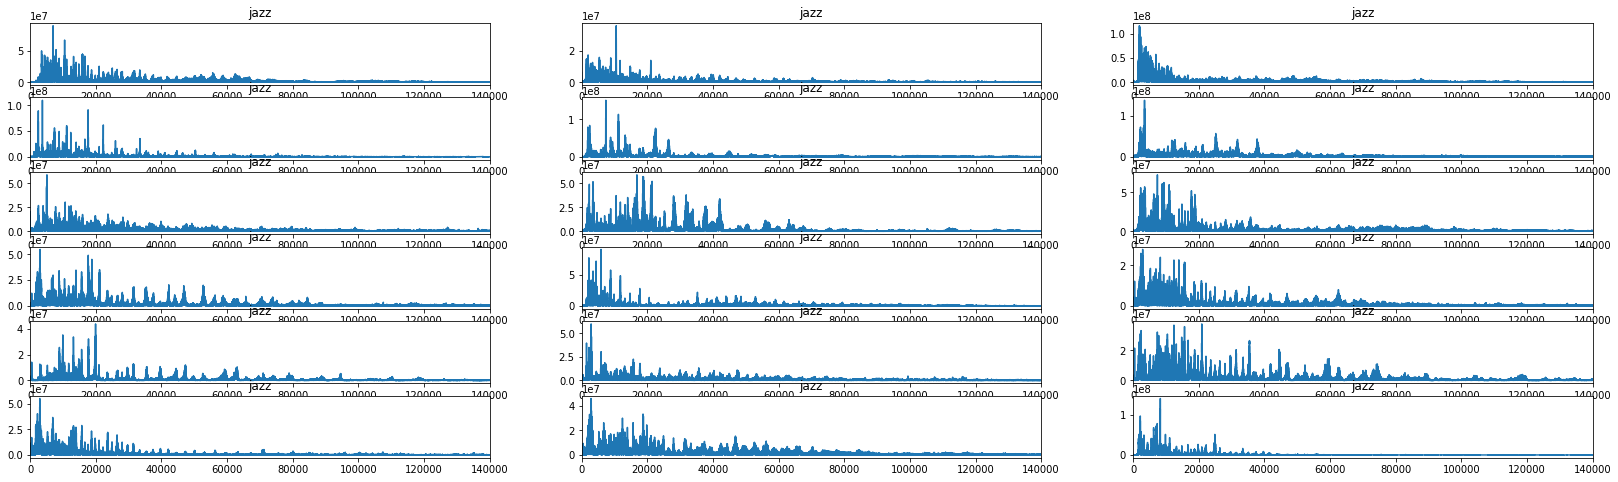

In [120]:
# abs value of continuous spectrum 
filter = 'jazz'

fig, axs = plt.subplots(nrows=6, ncols=3, figsize = (28,8))
ax = axs.flatten()
plot_idxs = y_label_exploration == filter
x_plot = x_data_exploration[plot_idxs]
for i in range(18):
  fs, data = x_plot[i]
  a = data # this is a two channel soundtrack, I get the first track
  c = fft(a) # calculate fourier transform (complex numbers list)
  d = len(c)/2  # if you only need half of the fft list (real signal symmetry)
  ax[i].plot(abs(c))
  ax[i].set_title(y_label_exploration[plot_idxs][i])
  ax[i].set_xlim(0,140000)

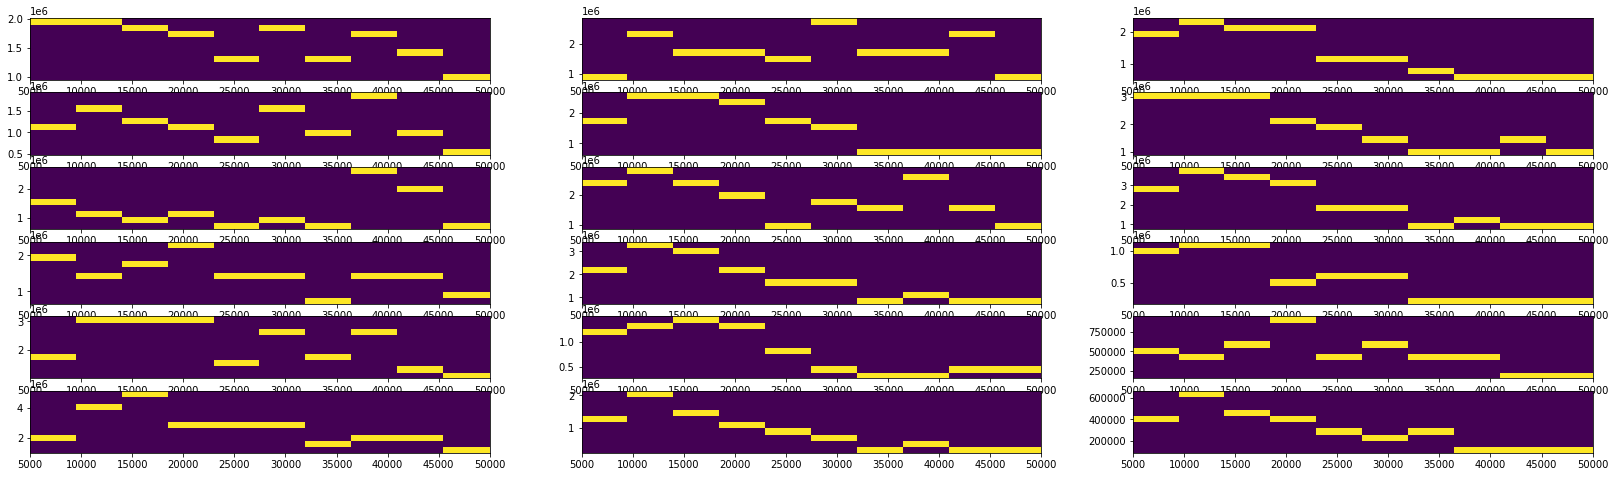

In [121]:
# explore frequency specrtum by classes

filter = 'classical'
size = 5000
classes = 10

fig, axs = plt.subplots(nrows=6, ncols=3, figsize = (28,8))
ax = axs.flatten()
plot_idxs = y_label_exploration == filter
x_plot = x_data_exploration[plot_idxs]
for i in range(18):
  fs, data = x_plot[i]
  a = data # this is a two channel soundtrack, I get the first track
  c = fft(a) # calculate fourier transform (complex numbers list)
  d = len(c)/2  # if you only need half of the fft list (real signal symmetry)
  
  fft_array = c[:int(d)]

  output = [np.mean(np.abs(fft_array[int(x):int(x+size)])) for x in np.linspace(0,(classes-1)*size,classes)]

  #plt.plot(c[:int(d)])
  ax[i].hist2d(np.linspace(size,size*classes,classes),output, bins=classes)